<a href="https://colab.research.google.com/github/AnupDesai/Machine_Learning_Tutorial_Op_Meterology/blob/main/Random_Forest_Machine_Learning_Tutorial_Op_Meterology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Tutorial for `A Machine Learning Tutorial for Operational Meteorology`**

**- Part III : Random Forest**


**Creator: Anup Desai**

**Affiliation: North Carolina Institite for Climate Studies**

# Overview

This notebook is an extension of the `Part I: Logistic Regression` and aims to provide formal instruction on one of the ubiquitious classification method : `Random Forests` on the same dataset used in the previous notebook, `SEVIR`.

> **Prerequisites**: Basic understanding of python programming and machine learning methods such as Decision Trees used for classification tasks.

> **Targeted Level**: This notebook aims to target and help beginners in Machine Learning.

> **Learning outcomes** : After going through this notebook, users can be confident in applying the Decision Trees on method to solve classifcation tasks on real-world datasets.

# Importing necessary python packages

> **We will follow the exact same steps in the Logistic Regression Notebook to import the data, divide the data into train, validation and test sets, fit/predict on the Random Forest and finally visualize the results using the ROC and Performance diagram curves.**

In [1]:
## Firstly let us install some packages that will help us to perform basic operations on data
!pip install geemap # This package will enable us to install geemap package to read our data

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 46.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.5/130.5 KB 5.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 48.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.5/46.5 KB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.4/55.4 KB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.6/98.6 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.6/99.6 KB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 43.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.7/3.7 MB 53.9

In [2]:
## Importing necessary python packages
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import requests
from pathlib import Path
import pandas as pd
import os
import geemap
import matplotlib as mp
import sklearn

## Importing some helper functions to perform fundamental operations on data
help_dict={"aux_functions.py":"https://raw.githubusercontent.com/AnupDesai/Machine_Learning_Tutorial_Op_Meterology/main/scripts/aux_functions.py",
          "gewitter_functions.py":"https://raw.githubusercontent.com/ai2es/WAF_ML_Tutorial_Part1/main/scripts/gewitter_functions.py"} ## Add the helper functions you want to add to the list

for help,url_link in help_dict.items():
  if Path(help).is_file():
    print(f"The helper function {help} already exists, skipping download")
  else:
    request= requests.get(url_link)
    print(f"Downloading the helper function script: {help}")
    with open(help,"wb") as h:
      h.write(request.content)

from aux_functions import show_vals,draw_zoom_window,get_right_units_vil, plot_feature_loc,load_n_combine_df

## setting up the plot parameters 
import matplotlib as mp
import matplotlib.pyplot as plt

mp.rcParams["axes.facecolor"] = [0.5,0.5,0.5] ## parameter makes a gray background to axis face
mp.rcParams["axes.titlesize"]= 12 
mp.rcParams["axes.labelsize"]= 14 # Fontsize
mp.rcParams["xtick.labelsize"]= 12
mp.rcParams["ytick.labelsize"]= 12
mp.rcParams["legend.fontsize"] = 12
mp.rcParams["legend.facecolor"] = 'w'
mp.rcParams["savefig.transparent"]= False

## Make default resolution higher
%config InlineBackend.figure_format = 'retina'


In [3]:
# Let us take a look the versions of the libraries we are using to be on the same page
print(f"xarray: {xr.__version__}")
print(f"matplotlib: {mp.__version__}")
print(f"numpy: {np.__version__}")
print(f"pandas: {pd.__version__}")
print(f"geemap: {geemap.__version__}")
print(f"Sklearn: {sklearn.__version__}")

xarray: 2022.12.0
matplotlib: 3.5.3
numpy: 1.22.4
pandas: 1.4.4
geemap: 0.20.1
Sklearn: 1.2.2


In [4]:
## Downloading .csv files 
csv_list= ["IR_stats_master.csv","WV_stats_master.csv","VIS_stats_master.csv","VIL_stats_master.csv","LI_stats_master.csv"]
for url in csv_list:
  if Path(url).is_file():
    print(f"The helper function {url} already exists, skipping download")
  else:
    url_link = "https://raw.githubusercontent.com/ai2es/WAF_ML_Tutorial_Part1/main/datasets/sevir/"
    request= requests.get(url_link +'/'+ url)
    print(f"Downloading the helper function script: {url}")
    with open(url,"wb") as h:
      h.write(request.content)

In [5]:
file_path = os.path.abspath('onestorm.nc')
if not os.path.exists(file_path):
    url = 'https://github.com/AnupDesai/Machine_Learning_Tutorial_Op_Meterology/blob/main/datasets/sevir/onestorm.nc'
    geemap.download_file(url)


Downloading...
From: https://raw.githubusercontent.com/AnupDesai/Machine_Learning_Tutorial_Op_Meterology/main/datasets/sevir/onestorm.nc
To: /content/onestorm.nc
100%|██████████| 39.1M/39.1M [00:00<00:00, 242MB/s]


> Load some data to visualize: The raw data here are in hdf5 file format (a common file type), but we will utilize data that is smaller and easier to deal with.

In [6]:
dataset = xr.open_dataset(file_path)
dataset

<xarray.Dataset>
Dimensions:            (x: 768, y: 768, t: 12, x2: 192, y2: 192, x3: 384,
                        y3: 384, x4: 48, y4: 48)
Dimensions without coordinates: x, y, t, x2, y2, x3, y3, x4, y4
Data variables:
    visible            (x, y, t) float32 ...
    water_vapor        (x2, y2, t) float32 ...
    clean_infrared     (x2, y2, t) float32 ...
    vil                (x3, y3, t) float32 ...
    lightning_flashes  (x4, y4, t) float32 ...
Attributes:
    t:        time dimension of all images. These are 5-min time steps
    x:        x pixel dimension of the visible imagery
    y:        y pixel dimension of the visible imagery
    x2:       x pixel dimension of the water vapor and infrared imagery
    y2:       y pixel dimension the water vapor and infrared imagery
    x3:       x pixel dimension of the vertically integrated liquid imagery
    y3:       y pixel dimension the vertically integrated liquid imagery
    x4:       x pixel dimension of the lightning flashes
    y4:       y pixel dimension of the lightning flashes

# Classification using Random Forests

> Before we jump into details of Machine Learning, we will recall the task to be accomplished in this notebook: **Classification**

  > Does a image from the SEVIR dataset contains a thunderstorm?

> To perform this Machine Learning task we wil use the ubiquitous `scikit-learn` also known as `sklearn` python package.

> Scikit-learn package has abundant resources to be used for various Machine Learning tasks. Additionally, the documentation on each method is detailed and extensive.

> As sklearn is a python package, all its methods and models have similar syntax. They follow a similar workflow as follows:

  * Create/load input data in shape of `[n_samples,n_features]`, commonly represented as `X`.
  
  * Create/load output data in shape of `[n_samples]`, commonly represented as `y`.
  
  * Initialize a model using just `()` at the end of the model name
  
  * Fit the model using `.fit(X,y)` method on the initialized model

  * Evaluate the model that has been fit to get the predictions in case of tasks like classification using `.predict(X_val)` or `.predict.proba(X_val)`.


> The above workflow is generally the norm of a Machine Learning task and scikit-learn package allows us to model this workflow in a pipeline with a few lines of code.










> We have loaded the data into our local environment, now we perform one of the most important steps in Machine Learning - splitting the dataset into train, validation and test subsets. Although the paper delves deep into this concept, we perform this action to make sure that our model does not get a taste of the complete dataset and straight out overfits the data and also adjust our hyperparameters.

In [7]:
(X_train,y_train),(X_validate,y_validate),(X_test,y_test) = load_n_combine_df(path_to_data='/content/',features_to_keep=np.arange(0,1,1),class_labels=True)
# Looking at the shape of each set to make sure that they match what we expected
print('X_train, y_train shapes: {},{}'.format(X_train.shape,y_train.shape))
print('X_val, y_val shapes: {},{}'.format(X_validate.shape,y_validate.shape))
print('X_test, y_test shapes: {},{}'.format(X_test.shape,y_test.shape))                                       

X_train, y_train shapes: (446320, 1),(446320,)
X_val, y_val shapes: (82871, 1),(82871,)
X_test, y_test shapes: (89718, 1),(89718,)


> Now, let us try gauge the predictive power of the minimum brightness temperature from the infrared channel. To perform this action, we need to find the data samples that have lightning flashes and samples which do not.

> We will use the `np.where` function from numpy to find indices of `X` and `y` where the label is 1.

In [8]:
# Sort out samples with atleast 1 flash
idx_flash = np.where(y_train==1)[0]
# Sort out samples without flashes
idx_noflash = np.where(y_train==0)[0]

> For folks who have never used `np.where` before, visualizing the data is the best way to find out whether `idx_flash` and `idx_noflash` is working as expected.

(array([224262.,      0.,      0.]),
 array([-0.01,  0.01,  0.99,  1.01]),
 <BarContainer object of 3 artists>)

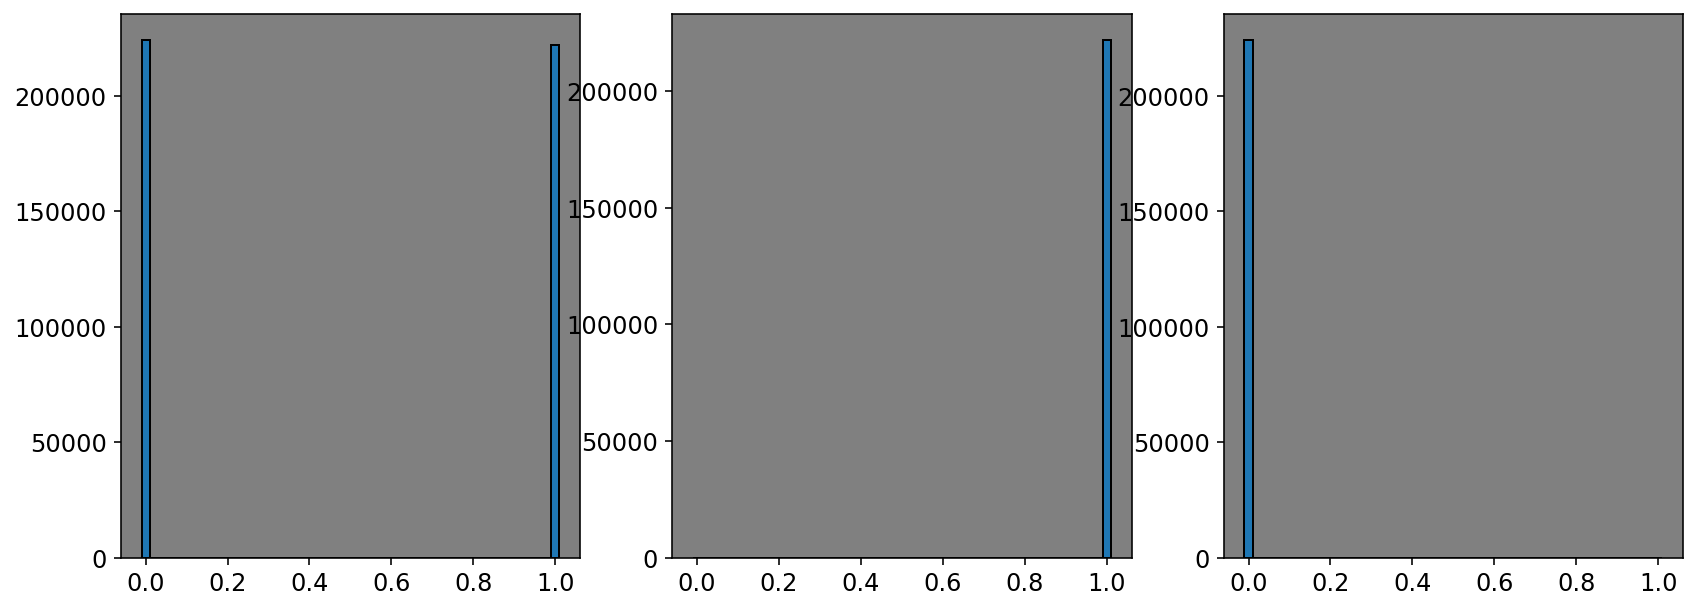

In [9]:
# The numpy function np.where theoretically gives us the results, but better we visualize it
plt.figure(figsize=(14,5))

plt.subplot(1,3,1)
plt.hist(y_train,bins=[-0.01,0.01,0.99,1.01], edgecolor='k')

plt.subplot(1,3,2)
plt.hist(y_train[idx_flash], bins=[-0.01,0.01,0.99,1.01],edgecolor='k')

plt.subplot(1,3,3)
plt.hist(y_train[idx_noflash], bins=[-0.01,0.01,0.99,1.01],edgecolor='k')

> Now that things look to be working properly, on a meteorological stand point let us plot the histogram of brightness temperature. 

> What is the expectation here ?

> The expectation here is that images with flashes will generally have colder minimum temperatures as they will have stronger storms.

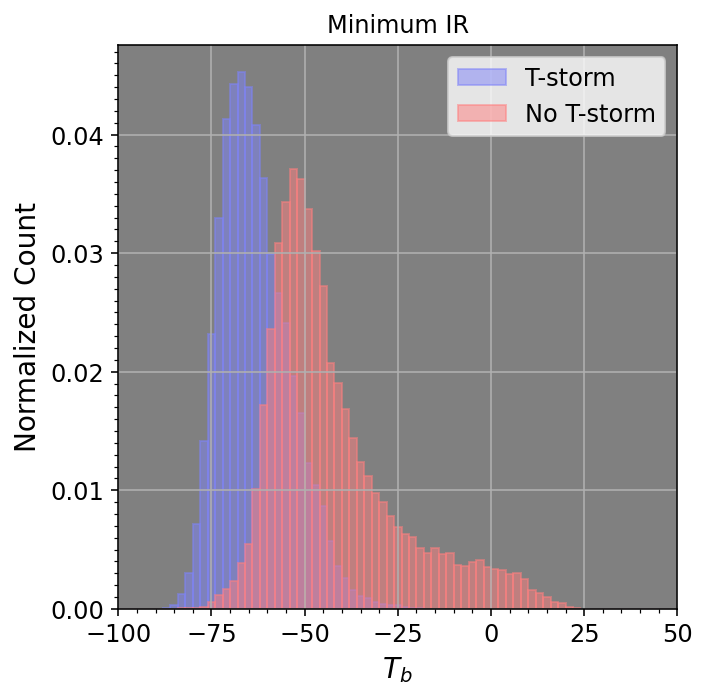

In [10]:
# Place ticker where we want them to be placed
from matplotlib.ticker import MultipleLocator,FormatStrFormatter,AutoMinorLocator

# Create an array of bins to create the histograms
xbins = np.arange(-100,50,2)

r= [255/255, 127/255, 127/255]
b = [126/255, 131/255, 248/255]

# Create the figure
figure= plt.figure(figsize=(5,5))
figure.set_facecolor('w')

#create axis for drawing
ax= plt.gca()

#draw histograms on the axis using matplotlib's histogram function
ax.hist(X_train[idx_flash,0], density=True, bins=xbins, color=b, alpha=0.5, zorder=0, label='T-storm', edgecolor=b)
ax.hist(X_train[idx_noflash,0], density=True, bins=xbins, color=r, alpha=0.5, zorder=0, label='No T-storm', edgecolor=r)

# add title and axis labels
ax.set_title('Minimum IR')
ax.set_ylabel('Normalized Count')
ax.set_xlabel('$T_{b}$')

# Set the tick locations using the above import functions
ax.xaxis.set_minor_locator(MultipleLocator(5))
ax.yaxis.set_minor_locator(MultipleLocator(0.001))

# Set axis limit
ax.set_xlim([-100,50])
ax.grid('on')
ax.legend()

plt.tight_layout()

> The above histogram, follows our expectation, there seems to a decision boundary to separate the two classes. 

> Time to train a Random Forest Classifier model now!

In [11]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
print(model)

RandomForestClassifier()


> Time to fit the model and obtain the predictions by using `.predict` function from sklearn.



In [12]:
# Time to train the model
model = model.fit(X_train,y_train)
y_preds= model.predict(X_validate)

> Time to evaluate the metrics from the above model.

  1. To evaluate the metrics let us build a contigency table as shown below.


> 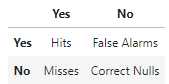



2. To provide a description on the above table, the left column is the model predictions and the top row is the observations.
    *   `True Positive`: if the model and observation predict `Yes`
    *   `False Positive`: if the model predicts `Yes` but the observation is `No`
    *   `False Positive`: if the model predicts `No` but the observation says `Yes`
    *   `True Negative`: if the model predicts `No` and the observation is `No`
    





> We will be using helper functions from gewitter_functions.py to obtain the contigency table and other metrics. There functions were written by Dr. Lagerquist during his PhD studies. 

> This notebook is about introducing Machine Learning hence, we will adapt these helper functions to run out of the box.

> We will also calculate the accuracy metric using `get_acc` function, from gewitter_functions.py

> Accuracy is generally calculated as 

>>>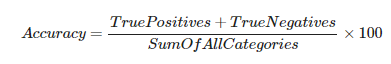

In [13]:
from gewitter_functions import get_contingency_table,get_acc,get_pod,get_sr,csi_from_sr_and_pod, make_performance_diagram_axis

cont_table = get_contingency_table(y_validate,y_preds)
print(f"Contigency Table : {cont_table}")

accuracy = get_acc(cont_table)
print(f"accuracy = {np.round(accuracy,0)}")


Contigency Table : {'num_true_positives': 33079, 'num_false_positives': 12986, 'num_false_negatives': 3808, 'num_true_negatives': 32998}
accuracy = 80.0


> 80% accuracy is a good result, as we are using 1 input. But as pointed out in the paper, it is always helpful to use more than one evaluation metric.

> Time to evaluate the performance of the model using the ROC and AUC curves as we did for the Logistic Regression model.

In [14]:
pod= get_pod(cont_table)
sr= get_sr(cont_table)
csi = csi_from_sr_and_pod(sr,pod)

print(f'POD : {np.round(pod,2)}, SR: {np.round(sr,2)}, CSI: {np.round(csi,2)}')

POD : 0.9, SR: 0.72, CSI: 0.66


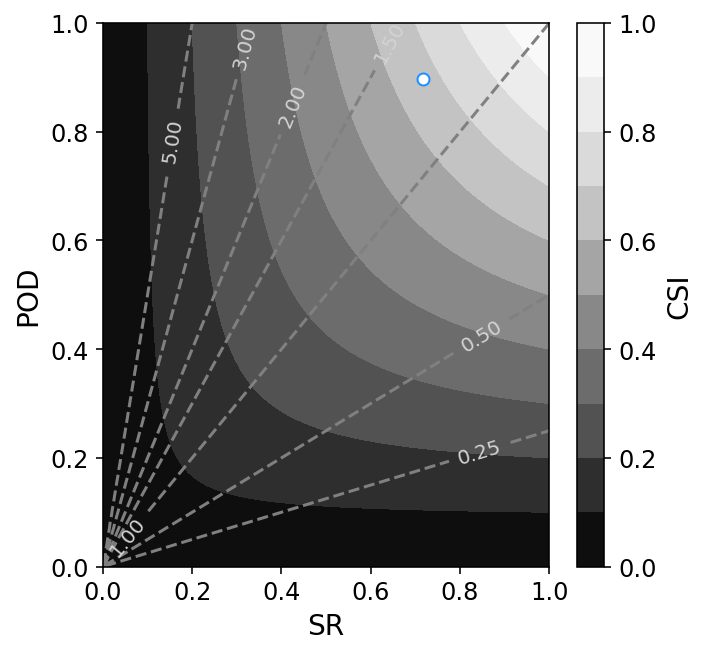

In [15]:
ax = make_performance_diagram_axis()
ax.plot(sr,pod,'o',color='dodgerblue',markerfacecolor='w')

> Here it is, the performance diagram of our Decision Tree model, using the learning from up above, we can assess that our model is actually performing quite well, with a large POD and SR 

> Now, let us consider more than 1 predictor to help predict whether there are thunderstorms or no thunderstorms.

> Since, we are using more than 1 predictor it is in the best practice to normalize the predictors. Scaling or normalizing the predictor is quite important as in reality each one our inputs have a range of valid values asssociated with them and the range can be as large as (-100,100) or as small as (0,1). 

> The machine learning will take into consideration these inputs quantitatively, so if we use the default inputs it might be biased to use the larger magnitude predictors more than the small predictors. 

> To prevent the bias we will scale the data to have `0` mean and `1` variance. We are likely more familiar with the standard anomaly


>>>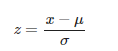

> We can write a helper function to implement the standard anamoly, but sklearn for the rescue again, sklearn has in built function for this: `sklearn.preprocessing.StandardScaler` which works a lot how we fit the machine learning model before.

In [16]:
from sklearn.preprocessing import StandardScaler

# Create the scaling object
scale = StandardScaler()

# Fit the Scaler to the training data
scale.fit(X_train)

# Transform the data 
X_train = scale.transform(X_train)
X_validate= scale.transform(X_validate)
X_test= scale.transform(X_test)

np.mean(X_train,axis=0), np.std(X_train,axis=0)

(array([1.73209916e-17]), array([1.]))

In [17]:
# Initializing the maximum iterations to not get a warning about converging
scaled_model = RandomForestClassifier()

# As we did for the above model we fit and get the predictions and the contigency table
scaled_model = scaled_model.fit(X_train,y_train)
y_pred = scaled_model.predict(X_validate)
cont_table = get_contingency_table(y_validate, y_pred)

# Looking up the dictionary
print(cont_table)

{'num_true_positives': 33151, 'num_false_positives': 12914, 'num_false_negatives': 3867, 'num_true_negatives': 32939}


In [18]:
# Calculating the accuracy

accuracy = get_acc(cont_table)
print(f'Accuracy = {accuracy}')

Accuracy = 79.75045552726526


> It is interesting to observe that the accuracy reduced after we scaled the data, which indicates that Random Forest may not be a suitable model for this dataset.

POD : 0.9, SR : 0.72, CSI: 0.66


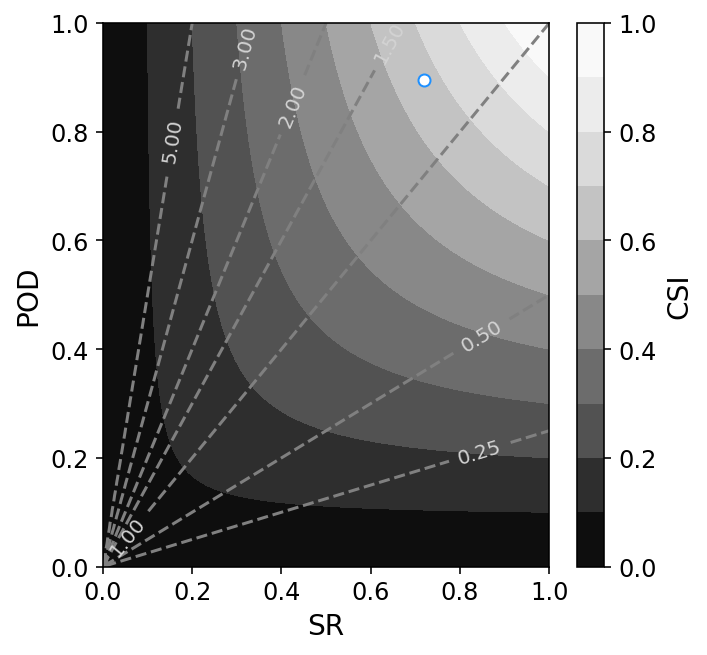

In [19]:
# To plot the performance diagram we need to calculate pod, sr and csi as we did for the above model

pod = get_pod (cont_table)
sr = get_sr (cont_table)
csi = csi_from_sr_and_pod(sr,pod)

# Looking up the results
print(f"POD : {np.round(pod,2)}, SR : {np.round(sr,2)}, CSI: {np.round(csi,2)}")

# Plotting the performance diagram using the above variables
ax = make_performance_diagram_axis()
ax.plot(sr, pod, 'o', color = 'dodgerblue', markerfacecolor='w')


> We observe that the CSI does not change much although we scaled the data. 

> Until now, we have been using `model.predict` to predict and out the predictions. This function is actually doing something us under the hood, the `model.predict` implements `model.predict_proba` which outputs a probability of each class, for example an image does not contain thunderstorm or contains thunderstorm, then model.predict takes the max of the two columns of probabilities to assign the class. 

> To put it into simple words, if the probability of the class 0 (no thunderstorm) is less than 0.5, then the label would be predicted as 1, and if it was greater than 0.5 it would be predicted as 0. This is a good place to start, but it is not always the case sometimes it is better define our own threshold.

In [20]:
# Get the prediction probabilities
y_pred_proba = scaled_model.predict_proba(X_validate)

print(f"Probabilitiy: {y_pred_proba[0]}, Label: {y_preds[0]}")

Probabilitiy: [0.69661761 0.30338239], Label: 0


> It is observed that the predicted probabilities for the first example shows a prediction around 69% for no lightning while 30% for lightning. Thus, a threshold of 0.5, which is assumed by the `model.predict()` shows that label is indeed 0.

> **Additional Metric: AUC of the ROC Curve**

  *   In the following few cells, an another metric and a diagram that is often used in Machine Learning for the classification task has been introduced. `The Area Under the Curve (AUC)` of the Reciever Operating Characterstic (ROC) curve.

  *  The ROC curve is similar to the performance diagram and is plotted with same axes as the performance diagram - `POD` and `POFD`
  
   

>>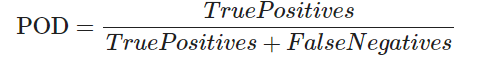

>>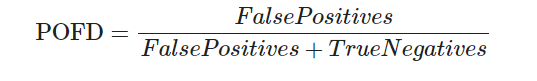

> Now, equipped with parameters we need to plot the ROC curve, we need to get the area under the ROC curve, to do that we use two helper functions from `gewitter_functions` - `get_points_in_roc_curve` and `get_area_under_roc_curve`

In [23]:
from gewitter_functions import get_points_in_roc_curve, get_area_under_roc_curve

# As we have done above, focussing on the output from class 1
y_preds = y_pred_proba[:,1]

pofds, pods = get_points_in_roc_curve(forecast_probabilities= y_preds, 
                                      observed_labels= y_validate, threshold_arg= np.linspace(0,1,100) )

AUC : 0.89


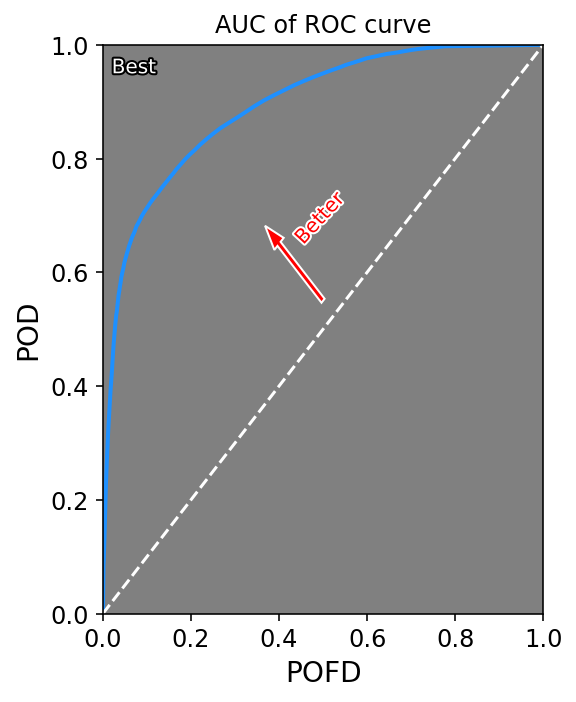

In [24]:
# Let's plot the ROC curve 

import matplotlib.patheffects as path_effects

pe = [path_effects.withStroke (linewidth=2, foreground='k')]
pe2 = [path_effects.withStroke(linewidth=2, foreground='w')]

# make the figure
fig = plt.figure(figsize=(4.1,5))
# Set the facecolor to white
fig.set_facecolor('w')

# plot the ROC curve
plt.plot(pofds, pods, color='dodgerblue', markerfacecolor='w', lw=2)

#Annotate the curve
plt.arrow(0.5,0.55, -0.1, 0.1, facecolor='r', zorder=5, width=0.01, edgecolor='w')
plt.text(0.43,0.65,'Better',rotation=47.5,color='r',path_effects=pe2)
plt.text(0.02,0.95,'Best',color='w',path_effects=pe,zorder=5)

# set limits
plt.xlim([0,1])
plt.ylim([0,1])

#set the no-skill line
plt.plot([0,1],[0,1],'--', color='white')
plt.title("AUC of ROC curve")
plt.xlabel('POFD')
plt.ylabel('POD')

plt.tight_layout()

# print out the AUC value
print(f"AUC : {np.round(get_area_under_roc_curve(pofds,pods),2)}")

> To conclude, A perfect performing model will have an AUC of 1, we have obtained an AUC of approximately 0.89 with our model which is good but not great. To elucidate visually, the closer our blue line is to the top left corner, the better the model is performing, but in contrast of if the line is near the diagonal, then the model has little to no skill or in simple terms it is just guesssing.

# Examples in the community

> Currently, there are numerous use cases of these Machine Learning methods in the real world. Taking the meteorology community into consideration, we observed a familiar example `Prediction of Thunderstorms` was used to contextualize the Machine Learning methods. The document `A Machine Learning Tutorial for Operational Meteorology. Part I: Conventional Machine Learning` discusses general machine learning methods as well as best practices to help meteorologists and readers use Machine learning to their own datasets.

# Data statement

> The dataset/data used in this notebook is obtained from the paper `A Machine Learning Tutorial for Operational Meteorology. Part I: Conventional Machine Learning` (`https://github.com/ai2es/WAF_ML_Tutorial_Part1/tree/main/datasets`)

# References

> This notebook refers to the following publication:

> Randy J. Chase et al: A Machine Learning Tutorial for Operational Meteorology. Part I: Conventional Machine Learning, https://journals.ametsoc.org/view/journals/wefo/37/8/WAF-D-22-0070.1.xml







